In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import isfile , join
from PIL import Image
from cvutils import segmentation_resize, rgb2gray


imgs_dir = 'images'
imgs1 = ['DNA_011.TIF', 'Pyramids2.jpg', 'Henry_Moore_Sculpture_0252.jpg']
imgs2 = ['DNA_011.TIF', 'Pyramids2.jpg', 'Henry_Moore_Sculpture_0252.jpg', 'IMG_4327.jpg', 'peppers.png']

imgs1_preprocessed = [segmentation_resize(np.array(Image.open(join(imgs_dir, f)))) for f in imgs1]
imgs2_preprocessed = [segmentation_resize(np.array(Image.open(join(imgs_dir, f)))) for f in imgs2]
# Images captured by iPhone (e.g 'IMG_4327.jpg') is transposed for unkown reason.
imgs2_preprocessed[3] = np.transpose(imgs2_preprocessed[3],(1,0,2))

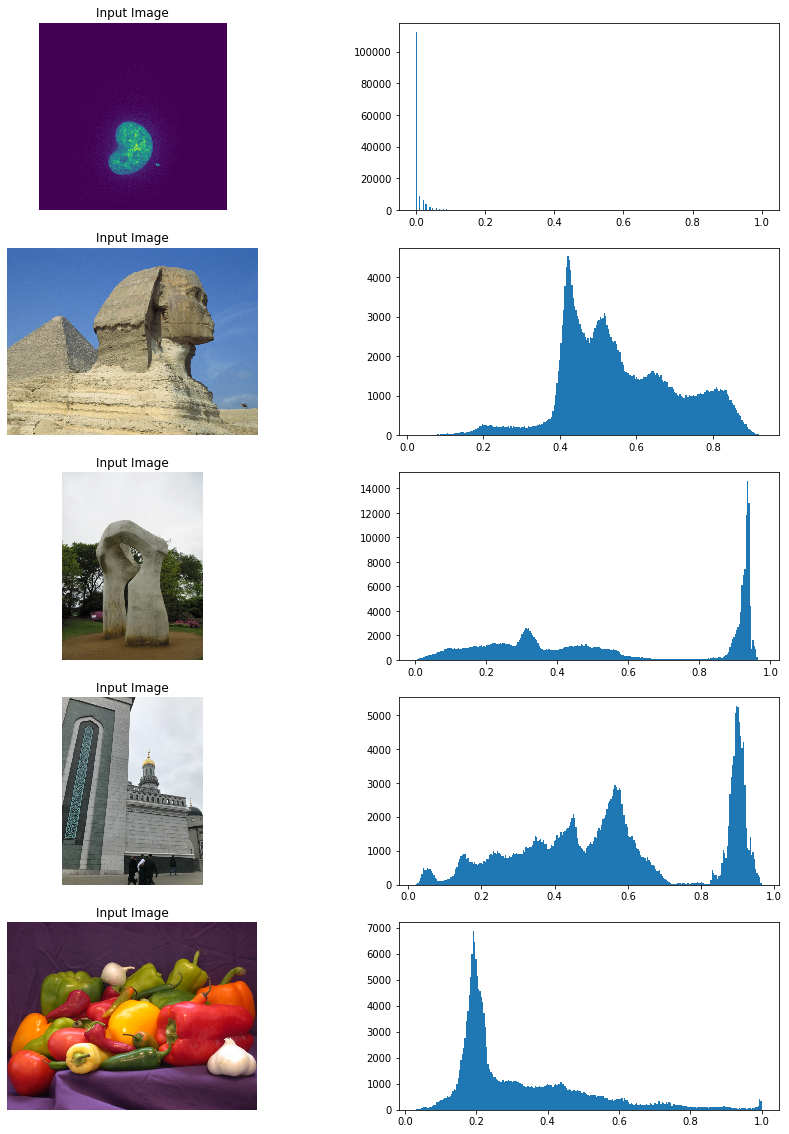

In [41]:
fig, ax = plt.subplots(len(imgs2),2,figsize = (15, 20))
for img_it in range(len(imgs2)):
    img = imgs2_preprocessed[img_it]
    subplot = ax[img_it,0]
    subplot.axis('off')
    subplot.imshow(img)
    subplot.set_title('Input Image')
    if len(img.shape) == 3:
        ax[img_it, 1].hist(rgb2gray(img).flatten(), 256)
    else:
        ax[img_it, 1].hist(img.flatten(), 256)

## Optimal Thresholding

![](media/optimal_thresholding.png)

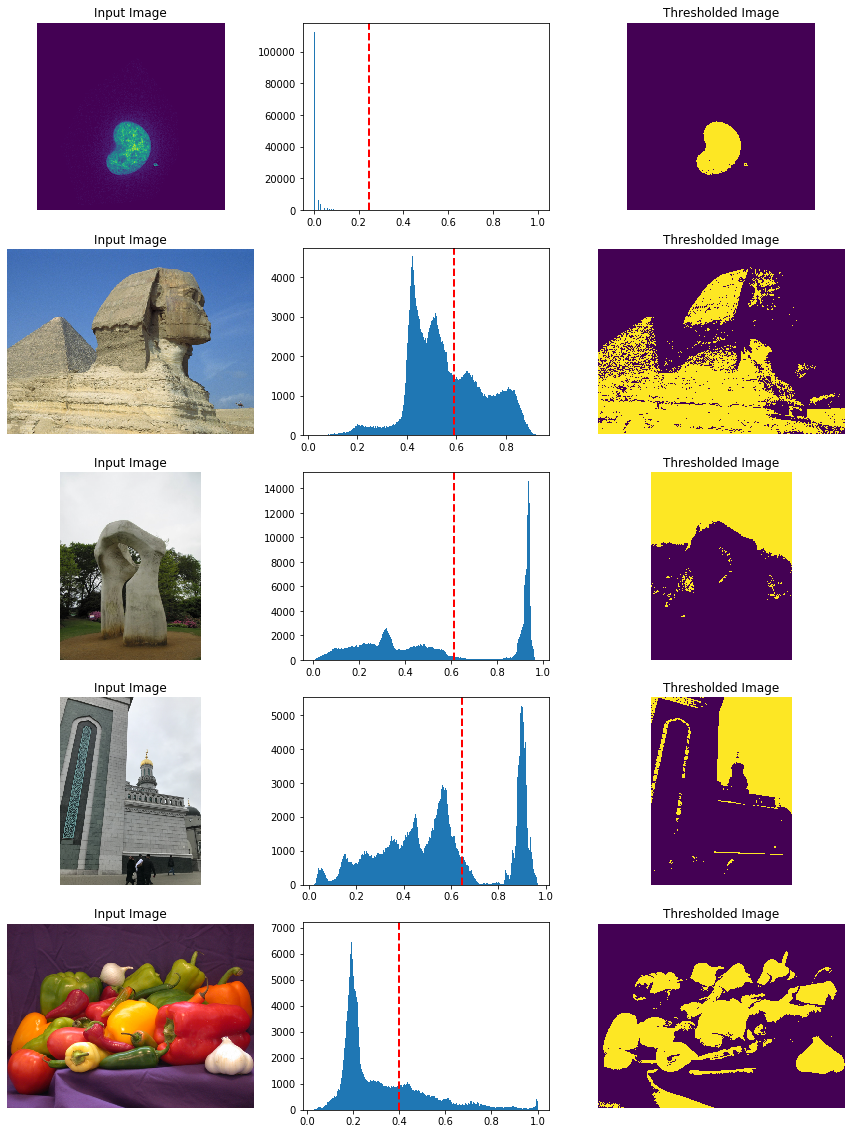

In [2]:
def optimal_thresholding(img):
    bg_sum = (img[0,0]+img[0,-1]+ img[-1, 0] + img[-1, -1])
    fg_sum = np.sum(img) - bg_sum
    bg_mean = bg_sum/4
    fg_mean = fg_sum/(np.size(img) - 4)
    t = (bg_mean + fg_mean)/2
    while True:
        bg_mean = np.mean(img[img < t])
        fg_mean = np.mean(img[img >= t])
        if t == (bg_mean+fg_mean)/2:
            break
        t = (bg_mean+fg_mean)/2
    return t

fig, ax = plt.subplots(len(imgs2),3,figsize = (15, 20))
for img_it in range(len(imgs2)):
    img = imgs2_preprocessed[img_it]
    ax[img_it,0].axis('off')
    ax[img_it,0].imshow(img)
    ax[img_it,0].set_title('Input Image')
    if len(img.shape) == 3: img = rgb2gray(img)
    
    t = optimal_thresholding(img)
    ax[img_it, 1].hist(img.flatten(), 256)
    ax[img_it, 1].axvline(x=t, color='r', linestyle='dashed', linewidth=2)
    
    ax[img_it,2].axis('off')
    ax[img_it,2].imshow(img >= t)
    ax[img_it,2].set_title('Thresholded Image')


## Otsu Thresholding
### Minimization of $\sigma_w^2(u)$

$$ \sigma_w^2(u) =  n_1 \sigma_1^2(u)  + n_2 \sigma_2^2(u)  $$


* Computation of $\sigma_w^2(u)$ at each $u$ is very costly
* can we do better?

## Otsu Thresholding
### Maxmimiztion of $\sigma_b^2(u)$

$$ 
\sigma^2 = \sigma_b^2(u) + \sigma_w^2(u) \\\ 
\sigma_w^2(u) = \sigma^2 - \sigma_b^2(u)
$$


$\therefore$ minimization of $\sigma_w^2(u)$ = maximization of $\sigma_b^2(u)$

## Otsu Thresholding
### Maxmimiztion of $\sigma_b^2(u)$


$$ 
\sigma^2 = \sigma_b^2(u) + \sigma_w^2(u) \\\ 
\sigma_w^2(u) = \sigma^2 - \sigma_b^2(u)
$$


$\therefore$ minimization of $\sigma_w^2(u)$ = maximization of $\sigma_b^2(u)$

## Otsu Thresholding
### Maxmimiztion of $\sigma_b^2(u)$


$$ \sigma_b^2(u) =  n_1 n_2 ( \mu_1(u) - \mu_2(u) )^2  $$


![](media/Otsu's_Method_Visualization.gif)

## Otsu Thresholding 
### Python implementation 

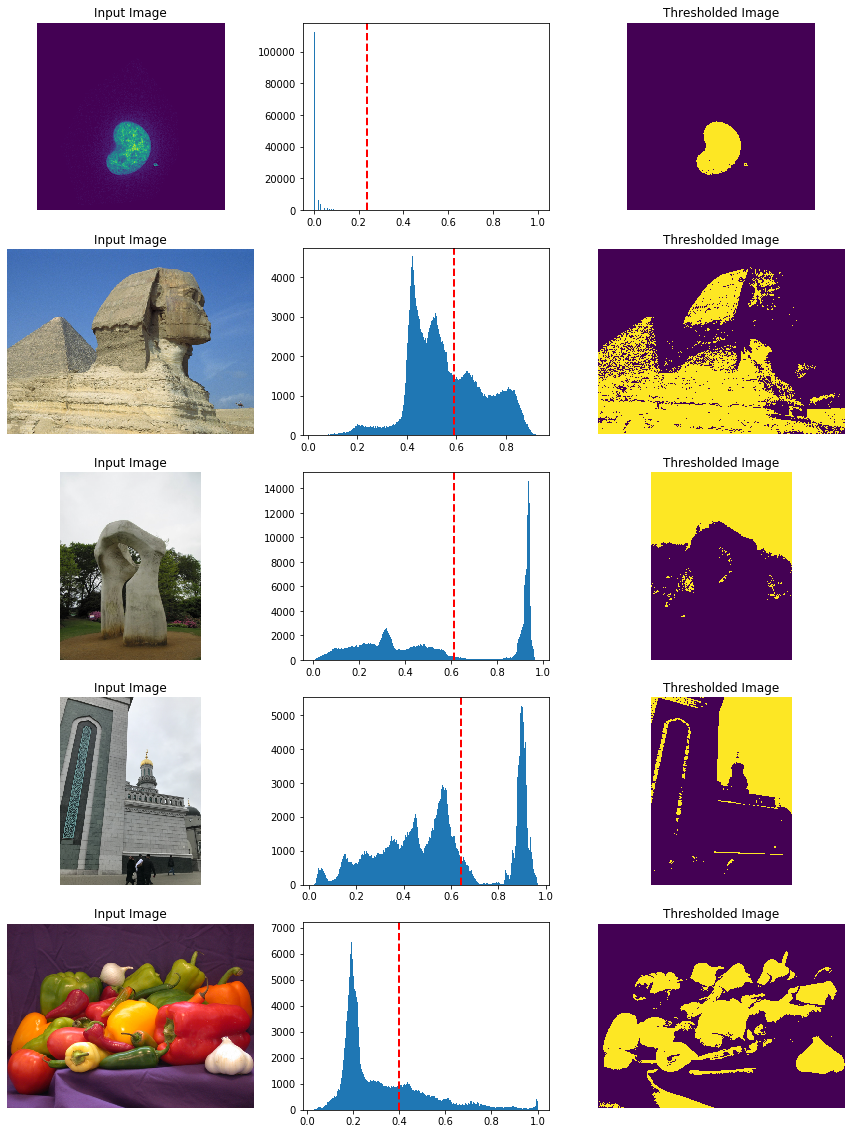

In [4]:
def otsu_threshold(img):
    im = ((img - img.min())*(1/(img.max() - img.min()))*255).astype('uint8')
    # Histogram
    pixel_counts = [np.sum(im == i) for i in range(256)]
    s_max = (0,-np.inf)
    
    for threshold in range(256):
        # update
        n1 = sum(pixel_counts[:threshold])
        n2 = sum(pixel_counts[threshold:])

        mu_1 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / n1 if n1 > 0 else 0       
        mu_2 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / n2 if n2 > 0 else 0

        # calculate between-variance
        s = n1 * n2 * (mu_1 - mu_2) ** 2

        if s > s_max[1]:
            s_max = (threshold, s)
    
    t = (s_max[0]/255)*(img.max()-img.min()) + img.min() 
    return t


fig, ax = plt.subplots(len(imgs2),3,figsize = (15, 20))
for img_it in range(len(imgs2)):
    img = imgs2_preprocessed[img_it]
    ax[img_it,0].axis('off')
    ax[img_it,0].imshow(img)
    ax[img_it,0].set_title('Input Image')
    if len(img.shape) == 3: img = rgb2gray(img)
    
    t = otsu_threshold(img)
    ax[img_it, 1].hist(img.flatten(), 256)
    ax[img_it, 1].axvline(x=t, color='r', linestyle='dashed', linewidth=2)
    
    ax[img_it,2].axis('off')
    ax[img_it,2].imshow(img >= t)
    ax[img_it,2].set_title('Thresholded Image')

## K-means Clustering

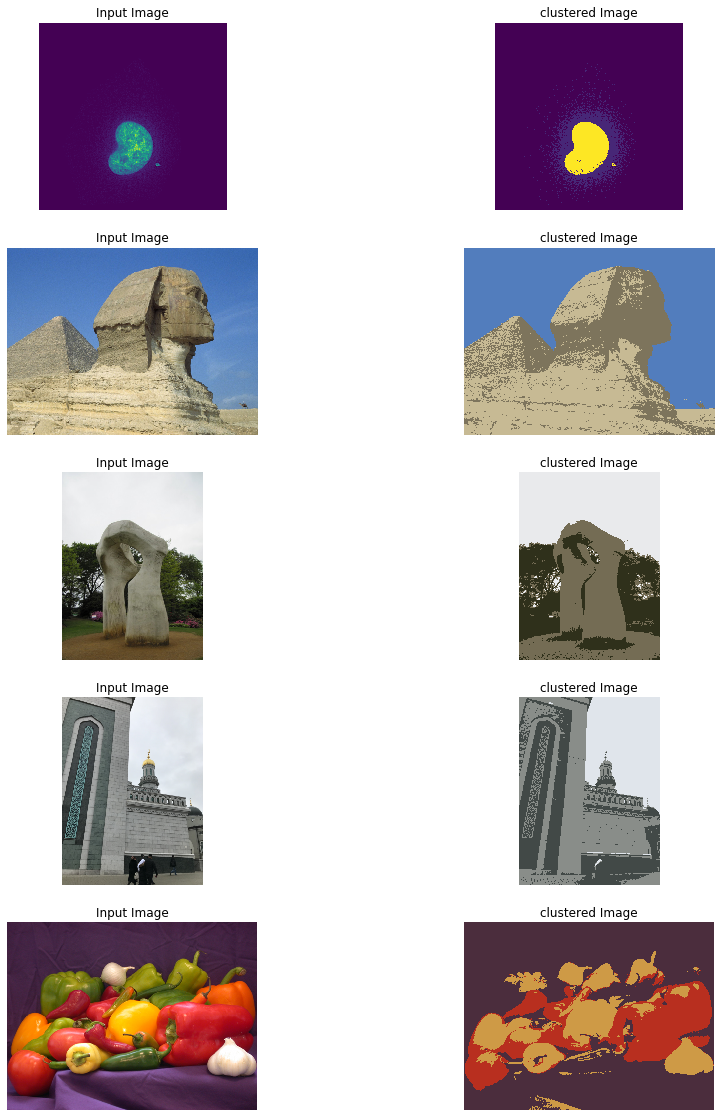

In [40]:
def kmeans_segmentation(image, nclusters, max_iterations = 4):
    
    img = np.array(image, copy = True, dtype = np.float)
    if len(img.shape) == 2: 
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))


    img_as_features = img.reshape(-1, img.shape[2])

    labels = np.zeros((img_as_features.shape[0],1))

    # Distance array ( featuresCount X CentroidsCount )
    distance = np.zeros((img_as_features.shape[0], nclusters), dtype = np.float)

    # Randomly sample from the feature vector initial points as centroids.
    centroids =  img_as_features[ np.random.choice(img_as_features.shape[0], nclusters, replace = False) ]

    for iteration in range(max_iterations) :
        for centroid_idx in range(centroids.shape[0]):
            distance[:, centroid_idx] = np.linalg.norm(img_as_features - centroids[centroid_idx], axis = 1)

        labels = np.argmin(distance, axis = 1)

        for centroid_idx in range(centroids.shape[0]):
            cluster = img_as_features[labels == centroid_idx]
            new_centroid = np.mean(cluster, axis = 0)
            centroids[centroid_idx] = new_centroid
            
        

    return centroids, labels


fig, ax = plt.subplots(len(imgs2),2,figsize = (15, 20))
for img_it in range(len(imgs2)):
    img = imgs2_preprocessed[img_it]
    ax[img_it,0].axis('off')
    ax[img_it,0].imshow(img)
    ax[img_it,0].set_title('Input Image')

    centroids, labels = kmeans_segmentation(img, 3)

    output  = centroids[labels.flatten()]
    output  = output.reshape(img.shape)
    
    ax[img_it,1].axis('off')
    ax[img_it,1].imshow(output)
    ax[img_it,1].set_title('clustered Image')